In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
inspector = inspect(engine)
inspector.get_table_names()


['measurement', 'station']

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results 

# Calculate the date 1 year ago from the last data point in the database
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(last_date)


('2017-08-23',)


In [12]:
#calculate year from last_date
last_year = dt.date(2017, 8 ,23) - dt.timedelta(days=365) 
print(last_year)

2016-08-23


In [13]:
# Perform a query to retrieve the date and precipitation scores
# Save the query results as a Pandas DataFrame and set the index to the date column

precipitation = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >'2016-08-22')
precipitation_df = pd.DataFrame(precipitation)
precipitation_df.count()

date    2230
prcp    2021
dtype: int64

In [14]:
#drop Non Values
precipitation_df =precipitation_df.dropna(how = "any")
precipitation_df.count()

date    2021
prcp    2021
dtype: int64

In [15]:
# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values("date")

precipitation_df = precipitation_df.set_index("date")


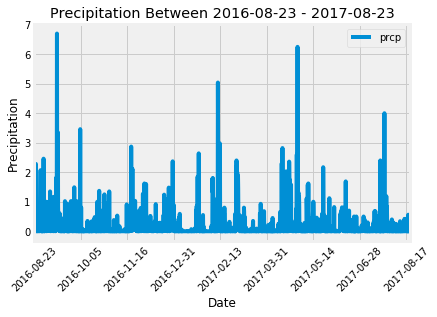

<Figure size 432x288 with 0 Axes>

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot()
plt.title("Precipitation Between 2016-08-23 - 2017-08-23")
plt.ylabel("Precipitation")
plt.xlabel("Date")
plt.xticks(rotation=45)

# Show plot
plt.show()

# Resize plot to display labels
plt.tight_layout()


In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [18]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(Station.station)).all()


[(9)]

In [19]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# Hint: You may need to use functions such as `func.min`, `func.max`, `func.avg`, and `func.count` in your queries.
active = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
order_by(func.count(Measurement.station).desc()).all()

active



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [20]:
print(f"Most Active: {active[0]}")

Most Active: ('USC00519281', 2772)


In [21]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?

In [22]:
sel = [Measurement.station, 
       func.min(Measurement.tobs), 
       func.max(Measurement.tobs), 
       func.avg(Measurement.tobs)]

temps= session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).first()


print(f"Station Number: {temps[0]}")
print(f"Lowest temperature: {temps[1]}")
print(f"Highest temperature: {temps[2]}")
print(f"Average temperature: {temps[3]}")


Station Number: USC00519281
Lowest temperature: 54.0
Highest temperature: 85.0
Average temperature: 71.66378066378067


In [23]:
tobs_twelve = session.query(Measurement.tobs)\
    .filter(Measurement.date > last_year)\
    .filter(Measurement.station == active[0][0])\
    .order_by(Measurement.tobs).all()

tobs_twelve=pd.DataFrame(tobs_twelve)
tobs_twelve.head()

,tobs
0,59.0
1,59.0
2,59.0
3,60.0
4,60.0


Text(0.5, 1.0, 'Temperature Observation for most active station in last 12 months')

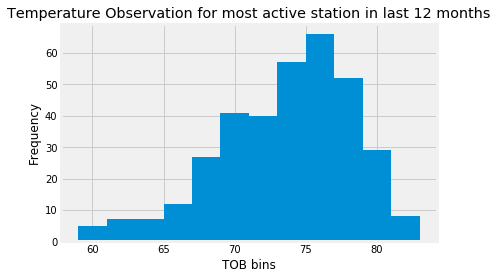

In [24]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

plt.hist(tobs_twelve['tobs'], bins=12)
plt.xlabel('TOB bins');
plt.ylabel('Frequency');
plt.title('Temperature Observation for most active station in last 12 months')


In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
prev_year=calc_temps('2016-12-25','2017-01-05' )
print(prev_year)

[(62.0, 70.23611111111111, 78.0)]


([], <a list of 0 Text xticklabel objects>)

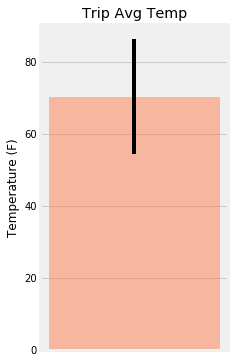

In [27]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
diff=(prev_year[0][2]-prev_year[0][0])
ave_temp=prev_year[0][1]
plt.figure(figsize=(3,6))
plt.bar(1, ave_temp, yerr=diff, alpha=.5, color="coral")
plt.ylabel('Temperature (F)')
plt.title('Trip Avg Temp')
plt.xticks([])


In [28]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation


my_trip = session.query(Measurement.station, Measurement.prcp, Station.latitude,Station.longitude,Station.elevation).\
                            group_by(Measurement.station).\
                            join(Station, Measurement.station == Station.station).\
                            filter(Measurement.date >= '2016-12-25').\
                            filter(Measurement.date <= '2017-01-05').\
                            order_by((Measurement.prcp).desc()).all()

my_trip

[('USC00516128', 0.38, 21.3331, -157.8025, 152.4),
 ('USC00513117', 0.03, 21.4234, -157.8015, 14.6),
 ('USC00519281', 0.02, 21.45167, -157.84888999999998, 32.9),
 ('USC00519397', 0.0, 21.2716, -157.8168, 3.0),
 ('USC00519523', 0.0, 21.33556, -157.71139, 19.5),
 ('USC00514830', None, 21.5213, -157.8374, 7.0),
 ('USC00517948', None, 21.3934, -157.9751, 11.9)]

## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]